In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from NEF_RL import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

In [80]:
rl = pd.read_pickle("data/RL_n_carrabin_1_dynamics.pkl")
nef100 = pd.read_pickle("data/NEF_RL_carrabin_1_dynamics_100neurons.pkl")
nef200 = pd.read_pickle("data/NEF_RL_carrabin_1_dynamics_200neurons.pkl")
nef300 = pd.read_pickle("data/NEF_RL_carrabin_1_dynamics_300neurons.pkl")
# nef500 = pd.read_pickle("data/NEF_RL_carrabin_1_dynamics_500neurons.pkl")
human = pd.read_pickle("data/carrabin.pkl").query("sid==1")

In [81]:
rl['neurons'] = 'RLn'
human['neurons'] = 'human'
nef100['neurons'] = '100'
nef200['neurons'] = '200'
nef300['neurons'] = '300'
# nef500['neurons'] = '500'
combined = pd.concat([human, rl, nef100, nef200, nef300], ignore_index=True)
combined['alpha'] = None
for i, row in combined.iterrows():
    mt = row['type']
    sid = row['sid']
    trial = row['trial']
    stage = row['stage']
    response = row['response']
    neurons = row['neurons']
    if stage>1:
        stage_old = stage - 1
        # print(mt, sid, trial, stage, stage_old)
        response_old = combined.query("type==@mt & neurons==@neurons & sid==@sid & trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
        delta = response_old - response
        color = human.query("sid==@sid & trial==@trial & stage==@stage")['color'].to_numpy()[0]
        prediction_error = color - response_old
        alpha = np.abs(delta / prediction_error)
        combined.at[i, 'alpha'] = alpha

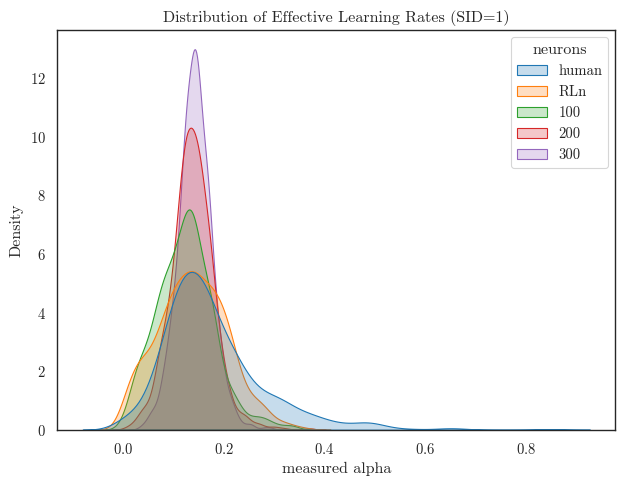

In [83]:
fig, ax = plt.subplots()
sns.kdeplot(combined, x='alpha', hue='neurons', ax=ax, palette=palette[:5], fill=True, common_norm=False)
plt.tight_layout()
ax.set(xlabel='measured alpha', title='Distribution of Effective Learning Rates (SID=1)')
fig.savefig("plots/alpha_distribution_sid1.jpg", dpi=600)